# TrashNet Prediction with EfficientNet-B4 Pretrained

## A. Import Data & Libraries

In [ ]:
import numpy as np
import pandas as pd

import os
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam
from torch import nn

from sklearn.metrics import classification_report
from torch.utils.data import random_split

%matplotlib inline

! pip install -q imutils
from imutils import paths
import shutil
from urllib.request import urlopen
from PIL import Image

import torchvision.models as models
from collections import OrderedDict

!pip install torch-summary

In [ ]:
#!wget https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip
!wget https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip

--2024-05-22 12:25:14--  https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.17, 18.164.174.23, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/76/6b/766b5d3fa3b4c589999f763b2dbbf7b7d8f28f754336cf4c836b1e91f7535b63/c060e8abfe5d6de0578ca15be1ed8ad0794a865d333c3473d53d1d9ad6e38b8c?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27dataset-resized.zip%3B+filename%3D%22dataset-resized.zip%22%3B&response-content-type=application%2Fzip&Expires=1716639914&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNjYzOTkxNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83Ni82Yi83NjZiNWQzZmEzYjRjNTg5OTk5Zjc2M2IyZGJiZjdiN2Q4ZjI4Zjc1NDMzNmNmNGM4MzZiMWU5MWY3NTM1YjYzL2MwNjBlOGFiZmU1ZDZkZTA1NzhjYTE1Ym

In [ ]:
!unzip dataset-resized.zip

Archive:  dataset-resized.zip
   creating: dataset-resized/
  inflating: dataset-resized/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset-resized/
  inflating: __MACOSX/dataset-resized/._.DS_Store  
   creating: dataset-resized/cardboard/
  inflating: dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset-resized/cardboard/cardboard108.jpg  
  inflating: dataset-resized/cardboard/cardboard109.jpg  
  inflating: dataset-resized/cardboard/cardboard11.j

## B. Preprocessing

### Setting Variables

In [ ]:
INPUT_HEIGHT = 224
INPUT_WIDTH  = 224

TRAIN = "train"
VAL = "val"
PATH = './dataset-resized/'

BATCH_SIZE = 8
VAL_SPLIT  = 0.15
EPOCHS = 50
LR = 1e-3

### Function Copy Image
To ease the splitting between Train and Val data

In [ ]:
def copy_images(imagePaths, folder):

    # Creating destination folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    # loop over the image paths
    for path in imagePaths:
        # Fetching name and label if the image and saving the files in training and validation folders
        imageName = path.split('/')[-1]
        label = path.split('/')[-2]
        labelFolder = os.path.join(folder, label)

        # Creating labelfolder if it doesn't exits
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)

        # construct the destination image path and copy the current image to it
        destination = os.path.join(labelFolder, imageName)
        shutil.copy(path, destination)

### Splitting Train & Val data

In [ ]:
print(">>> Loading Image paths...\n")

imagePaths = list(paths.list_images(PATH))
np.random.shuffle(imagePaths)

# Generating train & val paths
valPathsLen = int(len(imagePaths) * VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen

trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]

# Copying the training and validation images to their respective directories using the function above
print(">>> Copying training and validation images...")
copy_images(trainPaths, TRAIN)
copy_images(valPaths, VAL)

>>> Loading Image paths...

>>> Copying training and validation images...


### Function Visualize Batch
For visualization of a single batch from the dataset

In [ ]:
def visualize_batch(batch, classes, dataset_type):

    fig = plt.figure("{} batch".format(dataset_type), figsize=(BATCH_SIZE, BATCH_SIZE))

    for i in range(0, BATCH_SIZE):

        ax = plt.subplot(int(BATCH_SIZE/4), int(BATCH_SIZE/2), i + 1)

        '''grab the image, convert it from channels first ordering to
        channels last ordering, and scale the raw pixel intensities
        to the range [0, 255]'''

        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")

        idx = batch[1][i]
        label = classes[idx]

        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### Transforms

In [ ]:
# Images will be resized to 224x224 to follow the model's input requirement
resize = transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH))

In [ ]:
trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])

### Creating Dataset
To make DataLoader

In [ ]:
print(">>> Loading the training and validation dataset...\n")

trainDataset = ImageFolder(root = TRAIN, transform = trainTransforms)
valDataset = ImageFolder(root = VAL, transform = valTransforms)

print(">>> Training dataset contains {} samples...".format(len(trainDataset)))
print(">>> Validation dataset contains {} samples...".format(len(valDataset)))

>>> Loading the training and validation dataset...

>>> Training dataset contains 2148 samples...
>>> Validation dataset contains 379 samples...


In [ ]:
print(trainDataset)

Dataset ImageFolder
    Number of datapoints: 2148
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


### Create DataLoader
Which will be used for training

In [ ]:
print(">>> Creating training and validation set dataloaders...")

trainDataLoader = DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size = BATCH_SIZE)

>>> Creating training and validation set dataloaders...


In [ ]:
print(trainDataLoader)

>>> Visualizing training and validation batch...


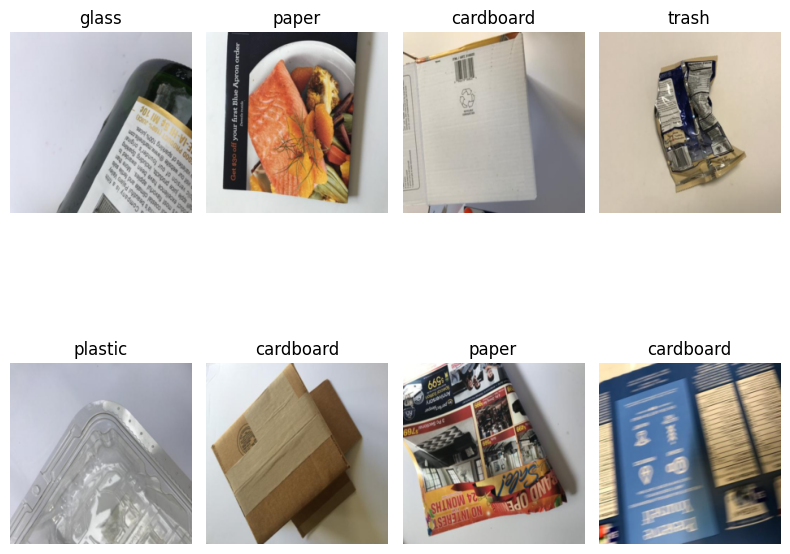

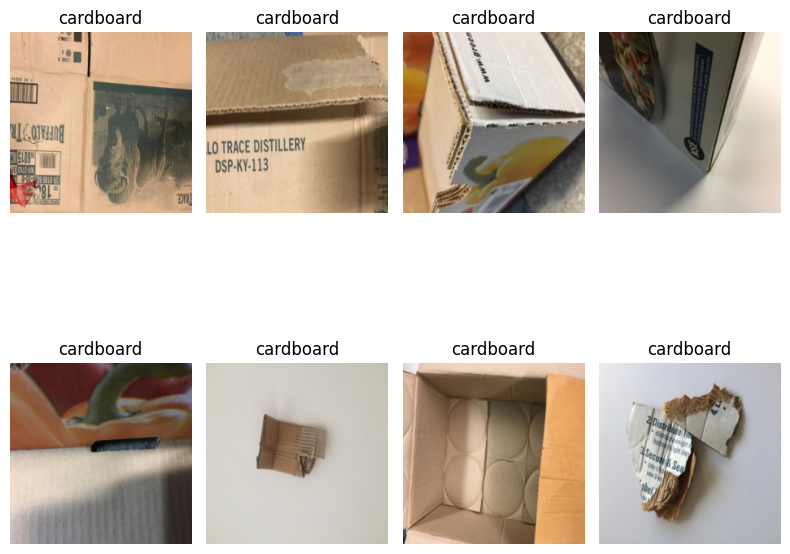

In [ ]:
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))

# Visualize the training and validation set batches using visualize_batch function defined above

print(">>> Visualizing training and validation batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")
visualize_batch(valBatch, valDataset.classes, "val")

## C. Loading Model

In [ ]:
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
# Load the EfficientNet B4 Pretrained model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
model.eval()

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1000, 100)),
    ('fc2', nn.Linear(100, 6)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc
model

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=48, out_features=12, bias=True)
          (expand): Linear(in_features=12, out_features=48, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
    

In [ ]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, (3,224,224))

Layer (type:depth-idx)                                       Output Shape              Param #
├─Sequential: 1-1                                            [-1, 48, 112, 112]        --
|    └─Conv2d: 2-1                                           [-1, 48, 112, 112]        1,296
|    └─BatchNorm2d: 2-2                                      [-1, 48, 112, 112]        96
|    └─SiLU: 2-3                                             [-1, 48, 112, 112]        --
├─Sequential: 1-2                                            [-1, 448, 7, 7]           --
|    └─Sequential: 2-4                                       [-1, 24, 112, 112]        --
|    |    └─MBConvBlock: 3-1                                 [-1, 24, 112, 112]        2,940
|    |    └─MBConvBlock: 3-2                                 [-1, 24, 112, 112]        1,206
|    └─Sequential: 2-5                                       [-1, 32, 56, 56]          --
|    |    └─MBConvBlock: 3-3                                 [-1, 32, 56, 56]         

Layer (type:depth-idx)                                       Output Shape              Param #
├─Sequential: 1-1                                            [-1, 48, 112, 112]        --
|    └─Conv2d: 2-1                                           [-1, 48, 112, 112]        1,296
|    └─BatchNorm2d: 2-2                                      [-1, 48, 112, 112]        96
|    └─SiLU: 2-3                                             [-1, 48, 112, 112]        --
├─Sequential: 1-2                                            [-1, 448, 7, 7]           --
|    └─Sequential: 2-4                                       [-1, 24, 112, 112]        --
|    |    └─MBConvBlock: 3-1                                 [-1, 24, 112, 112]        2,940
|    |    └─MBConvBlock: 3-2                                 [-1, 24, 112, 112]        1,206
|    └─Sequential: 2-5                                       [-1, 32, 56, 56]          --
|    |    └─MBConvBlock: 3-3                                 [-1, 32, 56, 56]         

## D. Train & Run with Wandb

### Install Wandb

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.6/281.6 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = model.to(device)
#model = Net(numChannels=3, classes=len(trainDataLoader.dataset.classes)).to(device)

opt = Adam(model.parameters(), lr=LR)
lossFn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

wandb.init(
    project="Tes Adamata",

    config={
    "learning_rate": 1e-3,
    "architecture": "EfficientNet B4",
    "dataset": "Trashnet",
    "epochs": 50,
    }
)

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "epoch": []
     }

startTime = time.time()

wandb: Currently logged in as: alfiano07 (vezice). Use `wandb login --relogin` to force relogin


### Train the model

In [ ]:
for e in range(0, EPOCHS):

    # Training
    model.train()

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0

    for (x, y) in trainDataLoader:

        (x, y) = (x.to(device), y.to(device))

        pred = model(x)
        loss = lossFn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Evaluation
    with torch.no_grad():

        model.eval()

        for (x, y) in valDataLoader:

            (x, y) = (x.to(device), y.to(device))

            pred = model(x)
            totalValLoss += lossFn(pred, y)

            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculating the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # Calculating the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset) # like correct/total
    valCorrect = valCorrect / len(valDataLoader.dataset)

    # Updating training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    H["epoch"].append(e)

    wandb.log({"train_loss": avgTrainLoss.cpu().detach().numpy(),
               "val_loss": avgValLoss.cpu().detach().numpy(),
               "train_acc": trainCorrect,
               "val_acc": valCorrect})

    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

    scheduler.step()
wandb.finish()

[INFO] EPOCH: 1/50
Train loss: 1.027552, Train accuracy: 0.6769
Val loss: 1.229041, Val accuracy: 0.6385

[INFO] EPOCH: 2/50
Train loss: 0.478905, Train accuracy: 0.8426
Val loss: 0.736068, Val accuracy: 0.7863

[INFO] EPOCH: 3/50
Train loss: 0.349750, Train accuracy: 0.8766
Val loss: 0.574833, Val accuracy: 0.7995

[INFO] EPOCH: 4/50
Train loss: 0.232894, Train accuracy: 0.9227
Val loss: 0.559926, Val accuracy: 0.8232

[INFO] EPOCH: 5/50
Train loss: 0.166676, Train accuracy: 0.9516
Val loss: 0.499638, Val accuracy: 0.8628

[INFO] EPOCH: 6/50
Train loss: 0.152935, Train accuracy: 0.9497
Val loss: 0.251963, Val accuracy: 0.9261

[INFO] EPOCH: 7/50
Train loss: 0.080364, Train accuracy: 0.9702
Val loss: 0.297806, Val accuracy: 0.9235

[INFO] EPOCH: 8/50
Train loss: 0.054925, Train accuracy: 0.9814
Val loss: 0.323341, Val accuracy: 0.9314

[INFO] EPOCH: 9/50
Train loss: 0.070138, Train accuracy: 0.9795
Val loss: 0.241568, Val accuracy: 0.9420

[INFO] EPOCH: 10/50
Train loss: 0.032760, Trai

In [ ]:
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Total time taken to train the model: 2259.19s


### Visualize the training progress

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = H['train_loss'],
                         x = H['epoch'],
                         name = 'train_loss',
                         mode = 'lines',
                         line = dict(dash='dot'),
                         marker =  dict(color = '#05ad24')))

fig.add_trace(go.Scatter(y = H['val_loss'],
                         x = H['epoch'],
                         name = 'val_loss',
                         mode = 'lines',
                         line = dict(dash='dot'),
                         marker =  dict(color = '#0688cf')))

fig.add_trace(go.Scatter(y = H['val_acc'],
                         x = H['epoch'],
                         name = 'val_acc',
                         mode = 'lines',
                         marker =  dict(color = '#0688cf')))

fig.add_trace(go.Scatter(y = H['train_acc'],
                         x = H['epoch'],
                         name = 'train_acc',
                         mode = 'lines',
                         marker =  dict(color = '#05ad24')))

fig.update_xaxes(title = '# Epoch',
        range = [0,51],
        tickfont = dict(size=15),
        tickmode = 'array',
        showline = False,
        showgrid = False,
        ticks = 'outside')

fig.update_yaxes(title = 'Loss/Accuracy',
        tickfont = dict(size=15),
        tickmode = 'array',
        showline = False,
        showgrid = True,
        ticks = 'outside')

fig.update_layout(width=600,
                  title = dict(text = 'Training Loss and Accuracy on Dataset',
                               x = 0.5,
                               font = dict(size = 16, color ='#27302a',
                               family = 'monospace')),
                  plot_bgcolor='#fadcb4',
                  paper_bgcolor = '#fadcb4')

fig.show()

### Save Model

In [ ]:
torch.save(model, 'Trashnet_EfficientNetB4_Pretrained.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
colab_link = "/content/Trashnet_EfficientNetB4_Pretrained.pt"
gdrive_link = "/content/drive/MyDrive/data/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/data/Trashnet_EfficientNetB4_Pretrained.pt'

# Experiment: ResNet18 Pretrained

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import os
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam
from torch import nn

from sklearn.metrics import classification_report
from torch.utils.data import random_split

%matplotlib inline

! pip install -q imutils
from imutils import paths
import shutil
from urllib.request import urlopen
from PIL import Image

import torchvision.models as models
from collections import OrderedDict

!pip install torch-summary

In [ ]:
#!wget https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip
!wget https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip

--2024-05-21 06:49:28--  https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.74, 3.163.189.90, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/76/6b/766b5d3fa3b4c589999f763b2dbbf7b7d8f28f754336cf4c836b1e91f7535b63/c060e8abfe5d6de0578ca15be1ed8ad0794a865d333c3473d53d1d9ad6e38b8c?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27dataset-resized.zip%3B+filename%3D%22dataset-resized.zip%22%3B&response-content-type=application%2Fzip&Expires=1716533368&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNjUzMzM2OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83Ni82Yi83NjZiNWQzZmEzYjRjNTg5OTk5Zjc2M2IyZGJiZjdiN2Q4ZjI4Zjc1NDMzNmNmNGM4MzZiMWU5MWY3NTM1YjYzL2MwNjBlOGFiZmU1ZDZkZTA1NzhjYTE1YmUx

In [ ]:
!unzip dataset-resized.zip

Archive:  dataset-resized.zip
   creating: dataset-resized/
  inflating: dataset-resized/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset-resized/
  inflating: __MACOSX/dataset-resized/._.DS_Store  
   creating: dataset-resized/cardboard/
  inflating: dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset-resized/cardboard/cardboard108.jpg  
  inflating: dataset-resized/cardboard/cardboard109.jpg  
  inflating: dataset-resized/cardboard/cardboard11.j

In [ ]:
PATH = './dataset-resized/'

## Preprocessing

In [ ]:
INPUT_HEIGHT = 224
INPUT_WIDTH  = 224

TRAIN = "train"
VAL = "val"

BATCH_SIZE = 8
VAL_SPLIT  = 0.15
EPOCHS = 50
LR = 1e-3

In [ ]:
def copy_images(imagePaths, folder):

    # Creating destination folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    # loop over the image paths
    for path in imagePaths:
        # Fetching name and label if the image and saving the files in training and validation folders
        imageName = path.split('/')[-1]
        label = path.split('/')[-2]
        labelFolder = os.path.join(folder, label)

        # Creating labelfolder if it doesn't exits
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)

        # construct the destination image path and copy the current image to it
        destination = os.path.join(labelFolder, imageName)
        shutil.copy(path, destination)

In [ ]:
print(">>> Loading Image paths...\n")

imagePaths = list(paths.list_images(PATH))
np.random.shuffle(imagePaths)

# Generating train & val paths

valPathsLen = int(len(imagePaths) * VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen

trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]

# Copying the training and validation images to their respective directories using the function above

print(">>> Copying training and validation images...")
copy_images(trainPaths, TRAIN)
copy_images(valPaths, VAL)

>>> Loading Image paths...

>>> Copying training and validation images...


In [ ]:
def visualize_batch(batch, classes, dataset_type):

    fig = plt.figure("{} batch".format(dataset_type), figsize=(BATCH_SIZE, BATCH_SIZE))

    # Looping over the batch size
    for i in range(0, BATCH_SIZE):

        # Creating a subplot
        ax = plt.subplot(int(BATCH_SIZE/4), int(BATCH_SIZE/2), i + 1)

        '''grab the image, convert it from channels first ordering to
        channels last ordering, and scale the raw pixel intensities
        to the range [0, 255]'''

        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")

        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx]

        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

    # show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
resize = transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH))

In [ ]:
trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])

In [ ]:
print(">>> Loading the training and validation dataset...\n")

trainDataset = ImageFolder(root = TRAIN, transform = trainTransforms)
valDataset = ImageFolder(root = VAL, transform = valTransforms)

print(">>> Training dataset contains {} samples...".format(len(trainDataset)))
print(">>> Validation dataset contains {} samples...".format(len(valDataset)))

>>> Loading the training and validation dataset...

>>> Training dataset contains 2148 samples...
>>> Validation dataset contains 379 samples...


In [ ]:
print(trainDataset)

Dataset ImageFolder
    Number of datapoints: 2148
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [ ]:
print(">>> Creating training and validation set dataloaders...")

trainDataLoader = DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size = BATCH_SIZE)

>>> Creating training and validation set dataloaders...


In [ ]:
print(trainDataLoader)

>>> Visualizing training and validation batch...


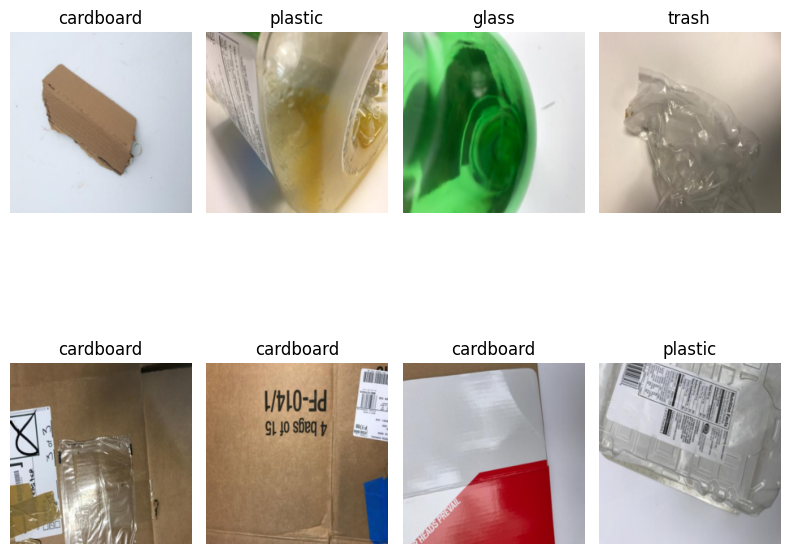

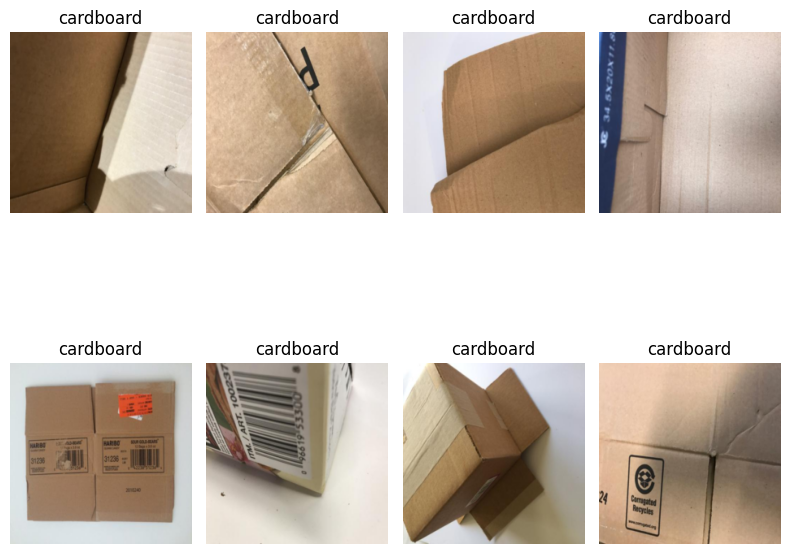

In [ ]:
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))

# visualize the training and validation set batches using visualize_batch function defined above

print(">>> Visualizing training and validation batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")
visualize_batch(valBatch, valDataset.classes, "val")

## Training!!

In [ ]:
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512, 100)),
    ('fc2', nn.Linear(100, 6)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


In [ ]:

from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, (3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

## Run with Wandb

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = model.to(device)
#model = Net(numChannels=3, classes=len(trainDataLoader.dataset.classes)).to(device)

opt = Adam(model.parameters(), lr=LR)
lossFn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

wandb.init(
    # set the wandb project where this run will be logged
    project="Tes Adamata",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-3,
    "architecture": "CNN",
    "dataset": "Trashnet",
    "epochs": 50,
    }
)

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "epoch": []
     }

startTime = time.time()

wandb: Currently logged in as: alfiano07 (vezice). Use `wandb login --relogin` to force relogin


In [ ]:
for e in range(0, EPOCHS):

    # Training
    model.train()

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0

    for (x, y) in trainDataLoader:

        (x, y) = (x.to(device), y.to(device))

        pred = model(x)
        loss = lossFn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Evaluation
    with torch.no_grad():

        model.eval()

        for (x, y) in valDataLoader:

            (x, y) = (x.to(device), y.to(device))

            pred = model(x)
            totalValLoss += lossFn(pred, y)

            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculating the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # Calculating the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset) # like correcct/total
    valCorrect = valCorrect / len(valDataLoader.dataset)

    # Updating training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    H["epoch"].append(e)

    wandb.log({"train_loss": avgTrainLoss.cpu().detach().numpy(),
               "val_loss": avgValLoss.cpu().detach().numpy(),
               "train_acc": trainCorrect,
               "val_acc": valCorrect})

    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

    scheduler.step()
wandb.finish()

[INFO] EPOCH: 1/50
Train loss: 0.445066, Train accuracy: 0.8589
Val loss: 1.257745, Val accuracy: 0.6860

[INFO] EPOCH: 2/50
Train loss: 0.268457, Train accuracy: 0.9106
Val loss: 1.243514, Val accuracy: 0.6623

[INFO] EPOCH: 3/50
Train loss: 0.244859, Train accuracy: 0.9111
Val loss: 0.947496, Val accuracy: 0.7573

[INFO] EPOCH: 4/50
Train loss: 0.223000, Train accuracy: 0.9311
Val loss: 1.741102, Val accuracy: 0.6201

[INFO] EPOCH: 5/50
Train loss: 0.132942, Train accuracy: 0.9590
Val loss: 0.706953, Val accuracy: 0.8259

[INFO] EPOCH: 6/50
Train loss: 0.123633, Train accuracy: 0.9558
Val loss: 1.619435, Val accuracy: 0.6596

[INFO] EPOCH: 7/50
Train loss: 0.086329, Train accuracy: 0.9688
Val loss: 0.613458, Val accuracy: 0.8470

[INFO] EPOCH: 8/50
Train loss: 0.061971, Train accuracy: 0.9758
Val loss: 0.659837, Val accuracy: 0.8470

[INFO] EPOCH: 9/50
Train loss: 0.051990, Train accuracy: 0.9842
Val loss: 0.565477, Val accuracy: 0.8681

[INFO] EPOCH: 10/50
Train loss: 0.037388, Trai

train_acc,▁▄▄▅▆▇▇▇▇▇▇█████████████████████████████
train_loss,█▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▂▄▁▂▇▇▇▆▃▇▆██▇▇▇█▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇
val_loss,▅▅▄█▇▂▂▂▂▆▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.99767
train_loss,0.00411
val_acc,0.87863
val_loss,0.47706


In [ ]:
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Total time taken to train the model: 911.47s


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = H['train_loss'],
                         x = H['epoch'],
                         name = 'train_loss',
                         mode = 'lines',
                         line = dict(dash='dot'),
                         marker =  dict(color = '#05ad24')))

fig.add_trace(go.Scatter(y = H['val_loss'],
                         x = H['epoch'],
                         name = 'val_loss',
                         mode = 'lines',
                         line = dict(dash='dot'),
                         marker =  dict(color = '#0688cf')))

fig.add_trace(go.Scatter(y = H['val_acc'],
                         x = H['epoch'],
                         name = 'val_acc',
                         mode = 'lines',
                         marker =  dict(color = '#0688cf')))

fig.add_trace(go.Scatter(y = H['train_acc'],
                         x = H['epoch'],
                         name = 'train_acc',
                         mode = 'lines',
                         marker =  dict(color = '#05ad24')))

fig.update_xaxes(title = '# Epoch',
        range = [0,51],
        tickfont = dict(size=15),
        tickmode = 'array',
        showline = False,
        showgrid = False,
        ticks = 'outside')

fig.update_yaxes(title = 'Loss/Accuracy',
        tickfont = dict(size=15),
        tickmode = 'array',
        showline = False,
        showgrid = True,
        ticks = 'outside')

fig.update_layout(width=600,
                  title = dict(text = 'Training Loss and Accuracy on Dataset',
                               x = 0.5,
                               font = dict(size = 16, color ='#27302a',
                               family = 'monospace')),
                  plot_bgcolor='#fadcb4',
                  paper_bgcolor = '#fadcb4')

fig.show()

In [ ]:
torch.save(model, 'Trashnet_ResNet18_Pretrained.pt')